# Chapter 13: Loading and Preprocessing Data with TensorFlow

In [1]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## The Data API

In [2]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

In [3]:
dataset = tf.data.Dataset.range(10)

In [4]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


### Chaining Transformations

In [5]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


In [6]:
dataset = dataset.map(lambda x: x*2)

In [7]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


In [8]:
dataset = dataset.unbatch()

In [9]:
dataset = dataset.filter(lambda x: x <10)

In [10]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


In [11]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)


In [12]:
for item in dataset.take(7):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)


### Shuffling the Data

In [13]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


#### Interleaving linges from multiple files

##### To run this example need to load California housing dataset and split into multiple files

In [14]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

In [15]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [16]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Peak at few lines of csv files

In [17]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Text mode

In [18]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [19]:
train_filepaths

['datasets\\housing\\my_train_00.csv',
 'datasets\\housing\\my_train_01.csv',
 'datasets\\housing\\my_train_02.csv',
 'datasets\\housing\\my_train_03.csv',
 'datasets\\housing\\my_train_04.csv',
 'datasets\\housing\\my_train_05.csv',
 'datasets\\housing\\my_train_06.csv',
 'datasets\\housing\\my_train_07.csv',
 'datasets\\housing\\my_train_08.csv',
 'datasets\\housing\\my_train_09.csv',
 'datasets\\housing\\my_train_10.csv',
 'datasets\\housing\\my_train_11.csv',
 'datasets\\housing\\my_train_12.csv',
 'datasets\\housing\\my_train_13.csv',
 'datasets\\housing\\my_train_14.csv',
 'datasets\\housing\\my_train_15.csv',
 'datasets\\housing\\my_train_16.csv',
 'datasets\\housing\\my_train_17.csv',
 'datasets\\housing\\my_train_18.csv',
 'datasets\\housing\\my_train_19.csv']

#### Building an input pipeline

In [20]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [21]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets\\housing\\my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets\\housing\\my_train_04.csv', sh

In [22]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1), # header,
    cycle_length=n_readers)

In [23]:
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


In [24]:
# Field 4 is interpreted as a string

record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [25]:
# Missing fields replaced with default value when provided

parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

In [26]:
# The 5th field is compulsory (since we provided tf.constant([]) as the "default value"), 
# so we get an exception if we do not provide it:

try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


In [27]:
# Number of fields should match exactly number of fields in record_defaults
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


### Preprocessing data

In [28]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

In [29]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

### Putting everything together

In [30]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

### Using the Dataset with tf.keras

In [31]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



In [32]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [33]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [34]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [35]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 2s 4ms/step - loss: 2.0914 - val_loss: 21.5124
Epoch 2/10
362/362 [==============================] - 0s 961us/step - loss: 0.8428 - val_loss: 0.6648
Epoch 3/10
362/362 [==============================] - 0s 947us/step - loss: 0.6329 - val_loss: 0.6196
Epoch 4/10
362/362 [==============================] - 0s 875us/step - loss: 0.5922 - val_loss: 0.5669
Epoch 5/10
362/362 [==============================] - 0s 837us/step - loss: 0.5622 - val_loss: 0.5402
Epoch 6/10
362/362 [==============================] - 0s 820us/step - loss: 0.5698 - val_loss: 0.5209
Epoch 7/10
362/362 [==============================] - 0s 828us/step - loss: 0.5195 - val_loss: 0.6130
Epoch 8/10
362/362 [==============================] - 0s 823us/step - loss: 0.5155 - val_loss: 0.4818
Epoch 9/10
362/362 [==============================] - 0s 825us/step - loss: 0.4965 - val_loss: 0.4904
Epoch 10/10
362/362 [==============================] - 0s 820us/step - loss: 0.4925

In [36]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 519us/step - loss: 0.4788


0.4787752032279968

In [37]:
new_set = test_set.map(lambda X, y: X)
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[2.3576407],
       [2.255291 ],
       [1.4437605],
       ...,
       [0.5654393],
       [3.9442453],
       [1.0232248]], dtype=float32)

In [38]:
# Create own training loop

optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
# Create TF function that performs whole training loop

optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [41]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [42]:
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


In [43]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
            func = getattr(tf.data.Dataset, m)
            if hasattr(func, "__doc__"):
                print("* {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

* apply()              Applies a transformation function to this dataset.
* as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
* batch()              Combines consecutive elements of this dataset into batches.
* cache()              Caches the elements in this dataset.
* cardinality()        Returns the cardinality of the dataset, if known.
* concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
* element_spec()       The type specification of an element of this dataset.
* enumerate()          Enumerates the elements of this dataset.
* filter()             Filters this dataset according to `predicate`.
* flat_map()           Maps `map_func` across this dataset and flattens the result.
* from_generator()     Creates a `Dataset` whose elements are generated by `generator`. (deprecated arguments)
* from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
* from_tensors()    

## The TFRecord Format

A TFRecord file is just a list of binary records. You can create one using a tf.io.TFRecordWriter

In [44]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [45]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one TFRecordDataset. By default it will read them one at a time, but if you set num_parallel_reads=3, it will read 3 at a time in parallel and interleave their records:

In [46]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


In [47]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

In [48]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


### A Brief Introduction to Protocol Buffers

Did not run this section due to issues with protoc.

In [49]:
# %%writefile person.proto
# syntax = "proto3";
# message Person {
#   string name = 1;
#   int32 id = 2;
#   repeated string email = 3;
# }

In [50]:
# !protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [51]:
# !ls person*

In [52]:
# from person_pb2 import Person

# person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
# print(person)  # display the Person

## Preprocessing the Input Features

Book code not contained in github repo for first part

### Encoding categorical features using one-hot vectors

In [53]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [54]:
fetch_housing_data()

In [55]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, 'housing.csv')
    return pd.read_csv(csv_path)

In [56]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [57]:
list(housing['ocean_proximity'].unique())

['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND']

In [58]:
vocab = list(housing['ocean_proximity'].unique())
indices = tf.range(len(vocab), dtype=tf.int64)
table_init = tf.lookup.KeyValueTensorInitializer(vocab, indices)
num_oov_buckets = 2
table = tf.lookup.StaticVocabularyTable(table_init, num_oov_buckets)

In [59]:
categories = tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'NEAR OCEAN', 'INLAND'])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 5, 2, 3, 2], dtype=int64)>

### Encoding Categorical Features Using Embeddings

In [60]:
embedding_dim = 2
embed_init = tf.random.uniform([len(vocab) + num_oov_buckets, embedding_dim])
embedding_matrix = tf.Variable(embed_init)

In [61]:
embedding_matrix

<tf.Variable 'Variable:0' shape=(7, 2) dtype=float32, numpy=
array([[0.6645621 , 0.44100678],
       [0.3528825 , 0.46448255],
       [0.03366041, 0.68467236],
       [0.74011743, 0.8724445 ],
       [0.22632635, 0.22319686],
       [0.3103881 , 0.7223358 ],
       [0.13318717, 0.5480639 ]], dtype=float32)>

In [62]:
categories = tf.constant(['NEAR BAY', 'DESERT', 'INLAND', 'NEAR OCEAN', 'INLAND'])
cat_indices = table.lookup(categories)
cat_indices

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 5, 2, 3, 2], dtype=int64)>

In [63]:
tf.nn.embedding_lookup(embedding_matrix, cat_indices)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[0.6645621 , 0.44100678],
       [0.3103881 , 0.7223358 ],
       [0.03366041, 0.68467236],
       [0.74011743, 0.8724445 ],
       [0.03366041, 0.68467236]], dtype=float32)>

In [64]:
embedding = keras.layers.Embedding(input_dim=len(vocab)+num_oov_buckets, output_dim = embedding_dim)

In [65]:
embedding(cat_indices)

<tf.Tensor: shape=(5, 2), dtype=float32, numpy=
array([[ 0.01878912, -0.00155212],
       [-0.02383961,  0.01973433],
       [ 0.0231154 ,  0.03925682],
       [ 0.04467482,  0.02493341],
       [ 0.0231154 ,  0.03925682]], dtype=float32)>

In [66]:
regular_inputs = keras.layers.Input(shape=[8])
categories = keras.layers.Input(shape=[], dtype=tf.string)
cat_indices = keras.layers.Lambda(lambda cats: table.lookup(cats))(categories)
cat_embed = keras.layers.Embedding(input_dim=6, output_dim=2)(cat_indices)
encoded_inputs = keras.layers.concatenate([regular_inputs, cat_embed])
outputs = keras.layers.Dense(1)(encoded_inputs)
model = keras.models.Model(inputs=[regular_inputs, categories], outputs = [outputs])

### Keras Processing Layers

Book version only contains summary code. Github repo doesn't contain anything. 

## TF Transform

In [67]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

## TensorFlow Datasets

In [68]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

In [69]:
print(tfds.list_builders())

['abstract_reasoning', 'accentdb', 'aeslc', 'aflw2k3d', 'ag_news_subset', 'ai2_arc', 'ai2_arc_with_ir', 'amazon_us_reviews', 'anli', 'arc', 'bair_robot_pushing_small', 'bccd', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'bool_q', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'cherry_blossoms', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'clic', 'clinc_oos', 'cmaterdb', 'cnn_dailymail', 'coco', 'coco_captions', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'coqa', 'cos_e', 'cosmos_qa', 'covid19sum', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'd4rl_mujoco_ant', 'd4rl_mujoco_halfcheetah', 'dart', 'davis', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'dolp

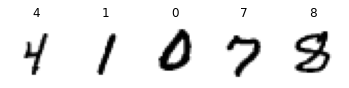

In [70]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

In [71]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [72]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [73]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 1s 698us/step - loss: 42.9108 - accuracy: 0.8034
Epoch 2/5
1875/1875 [==============================] - 1s 485us/step - loss: 24.8643 - accuracy: 0.8701
Epoch 3/5
1875/1875 [==============================] - 1s 481us/step - loss: 24.3896 - accuracy: 0.8718
Epoch 4/5
1875/1875 [==============================] - 1s 479us/step - loss: 23.5890 - accuracy: 0.8775
Epoch 5/5
1875/1875 [==============================] - 1s 532us/step - loss: 22.9626 - accuracy: 0.8798
